# About this notebook
This notebook was taken and changed from O'Reilly book Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow.

The task is to predict median house values in Californian districts, given a number of features from these districts.

This notebook contains all the sample code and solutions to the exercices in [chapter 2](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb).

# Setup

In [13]:
!python --version

Python 3.7.9


In [14]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the data

In [15]:
!pip freeze

cycler==0.11.0
joblib==1.0.1
kiwisolver==1.4.4
matplotlib==3.4.0
numpy==1.21.6
pandas==1.3.3
Pillow==9.5.0
pyparsing==3.1.0
python-dateutil==2.8.2
pytz==2023.3
scikit-learn==0.20.0
scipy==1.7.3
seaborn==0.12.2
six==1.16.0
typing_extensions==4.7.1


In [16]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets','housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)

  tgz_path = os.path.join(housing_path, 'housing.tgz')
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [17]:
# fetch_housing_data()
# print('Data downloaded!')

# Explore the data

In [18]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)

In [19]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [20]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [21]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [22]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


* 25% of the districts have a housing_median_age lower than 18
* 50% are lower than 29
* 75% are lower than 37

Saving figure attribute_histogram_plots


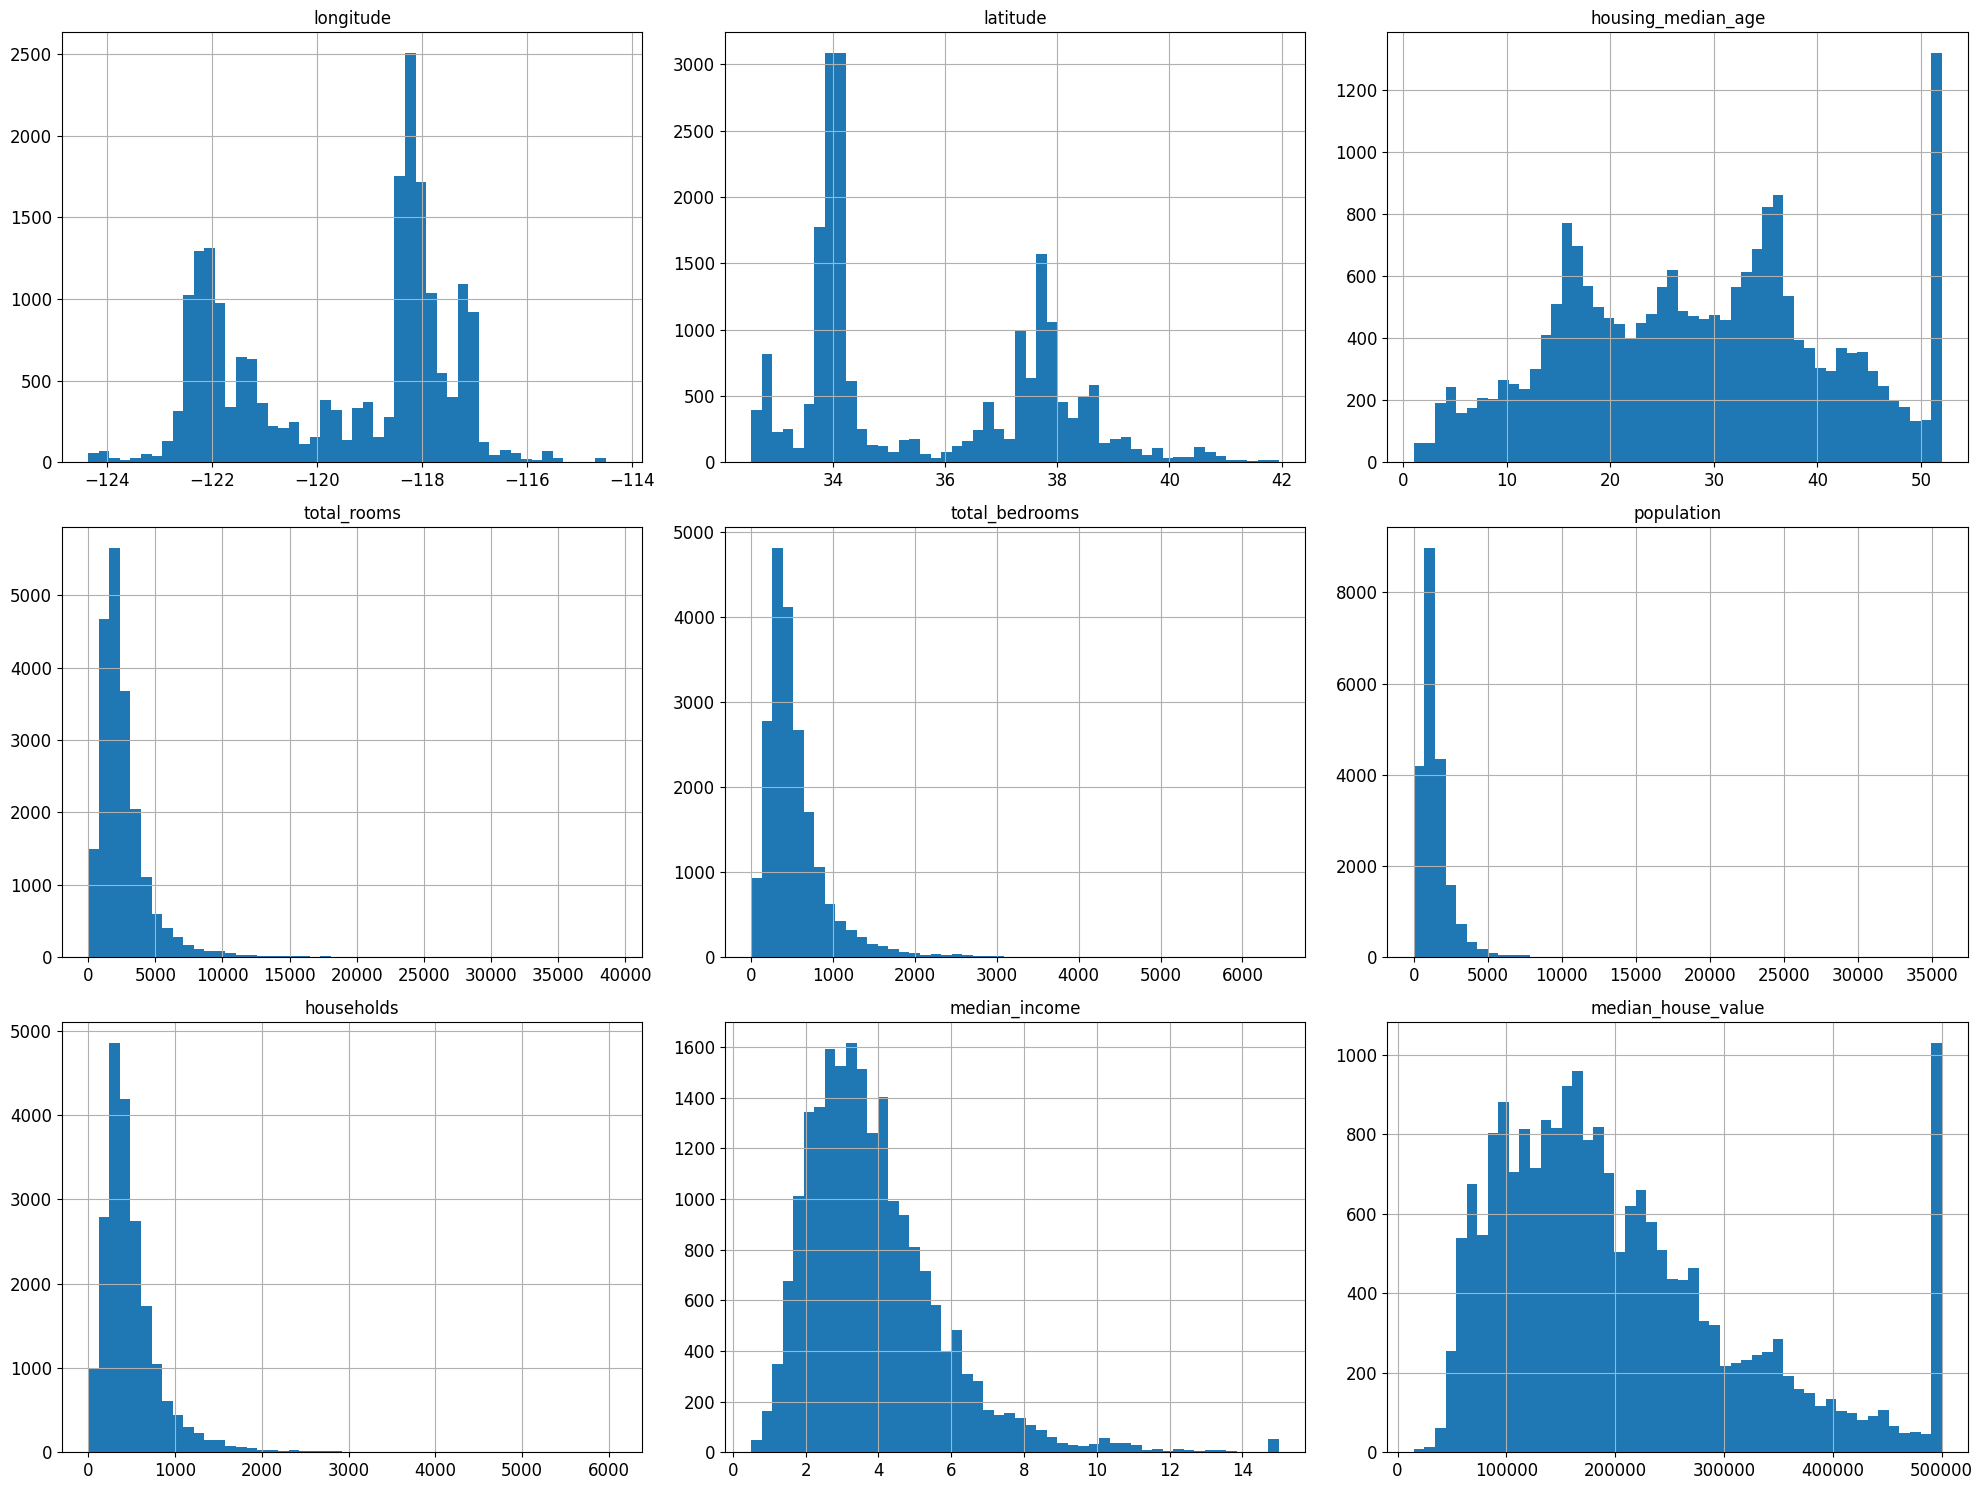

In [23]:
# Showing the number of instances (on the vertical axis) that have a given value range (on the horizontal axis)
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig('attribute_histogram_plots')
plt.show()

Few things to notice in the above histograms:

1.   First, the median income attribute does not look like it is expressed in US dollars (USD), but the numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about \$30,000).

2.   The housing meadian age and the median house value were also capped. This may be a serious problem since it is the target attribute (the labels). The ML algorithm may learn that prices never go beyond that limit. If required precise predictions even beyond \$500,000, the options are:
    
    a. Collect proper labels for the districts whose labels were capped.
    
    b. Remove those districts from the training and test set.

3.   These attributes have very different scales, is neccesary to apply feature scaling.

4.   Many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. Future transformations to these attributes have to be done in order to have more bell-shaped distributions.

Visualizing the data to have a better overview of how it is distributed with a kernel density estimate (KDE) plot, which is a method for visualizing the distribution of observations in a dataset.

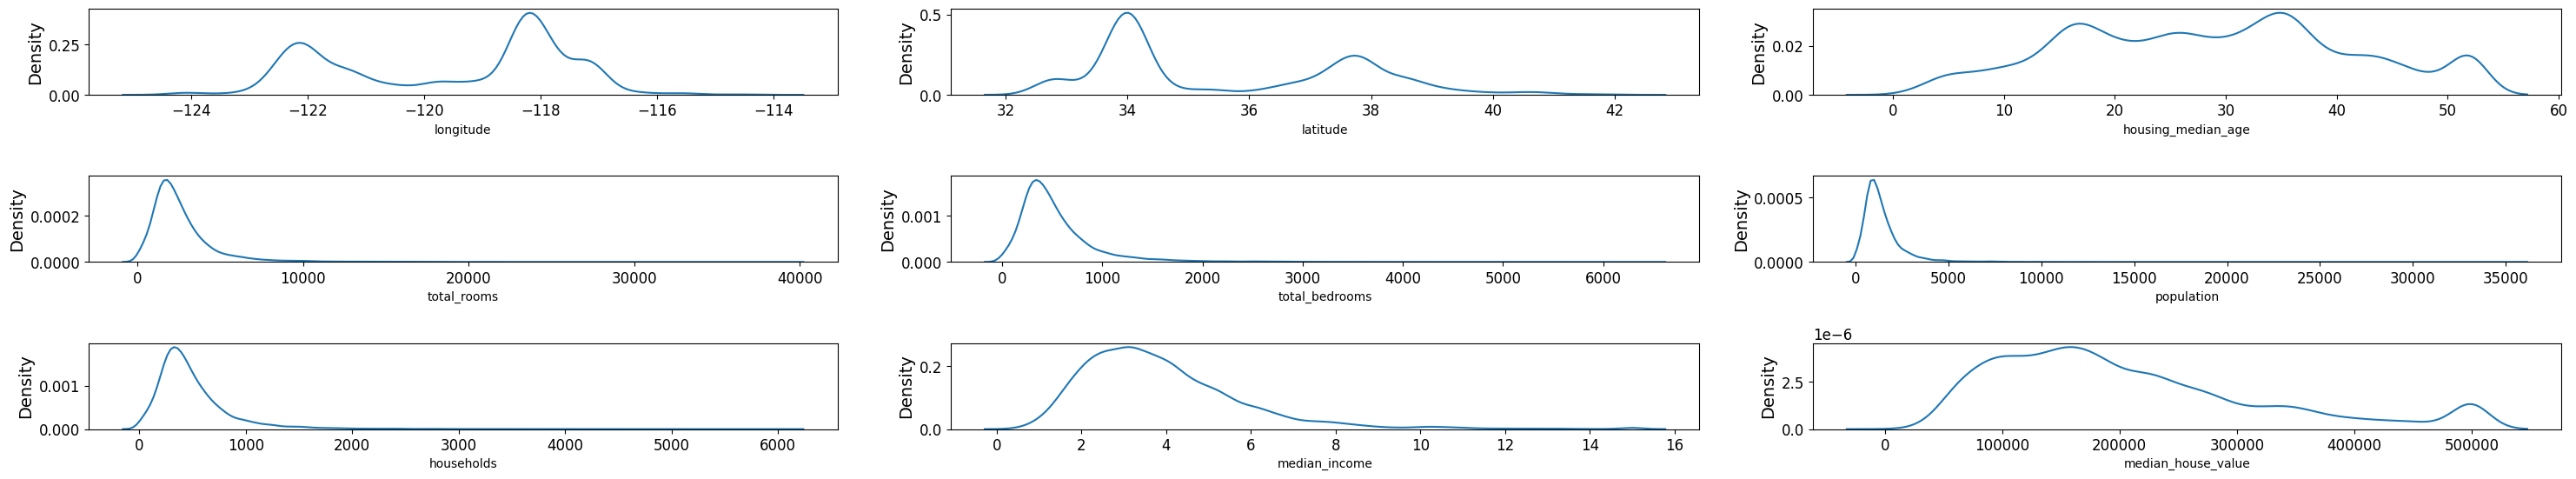

In [24]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(30,40))
for i, col in enumerate(housing.columns):
    if housing[col].dtype != 'object':
        ax = plt.subplot(21, 3, i+1)
        sns.kdeplot(housing[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)

plt.show()

Then, in order to have a better view of quartiles of the dataset, and the outliers, let's plot some boxes.

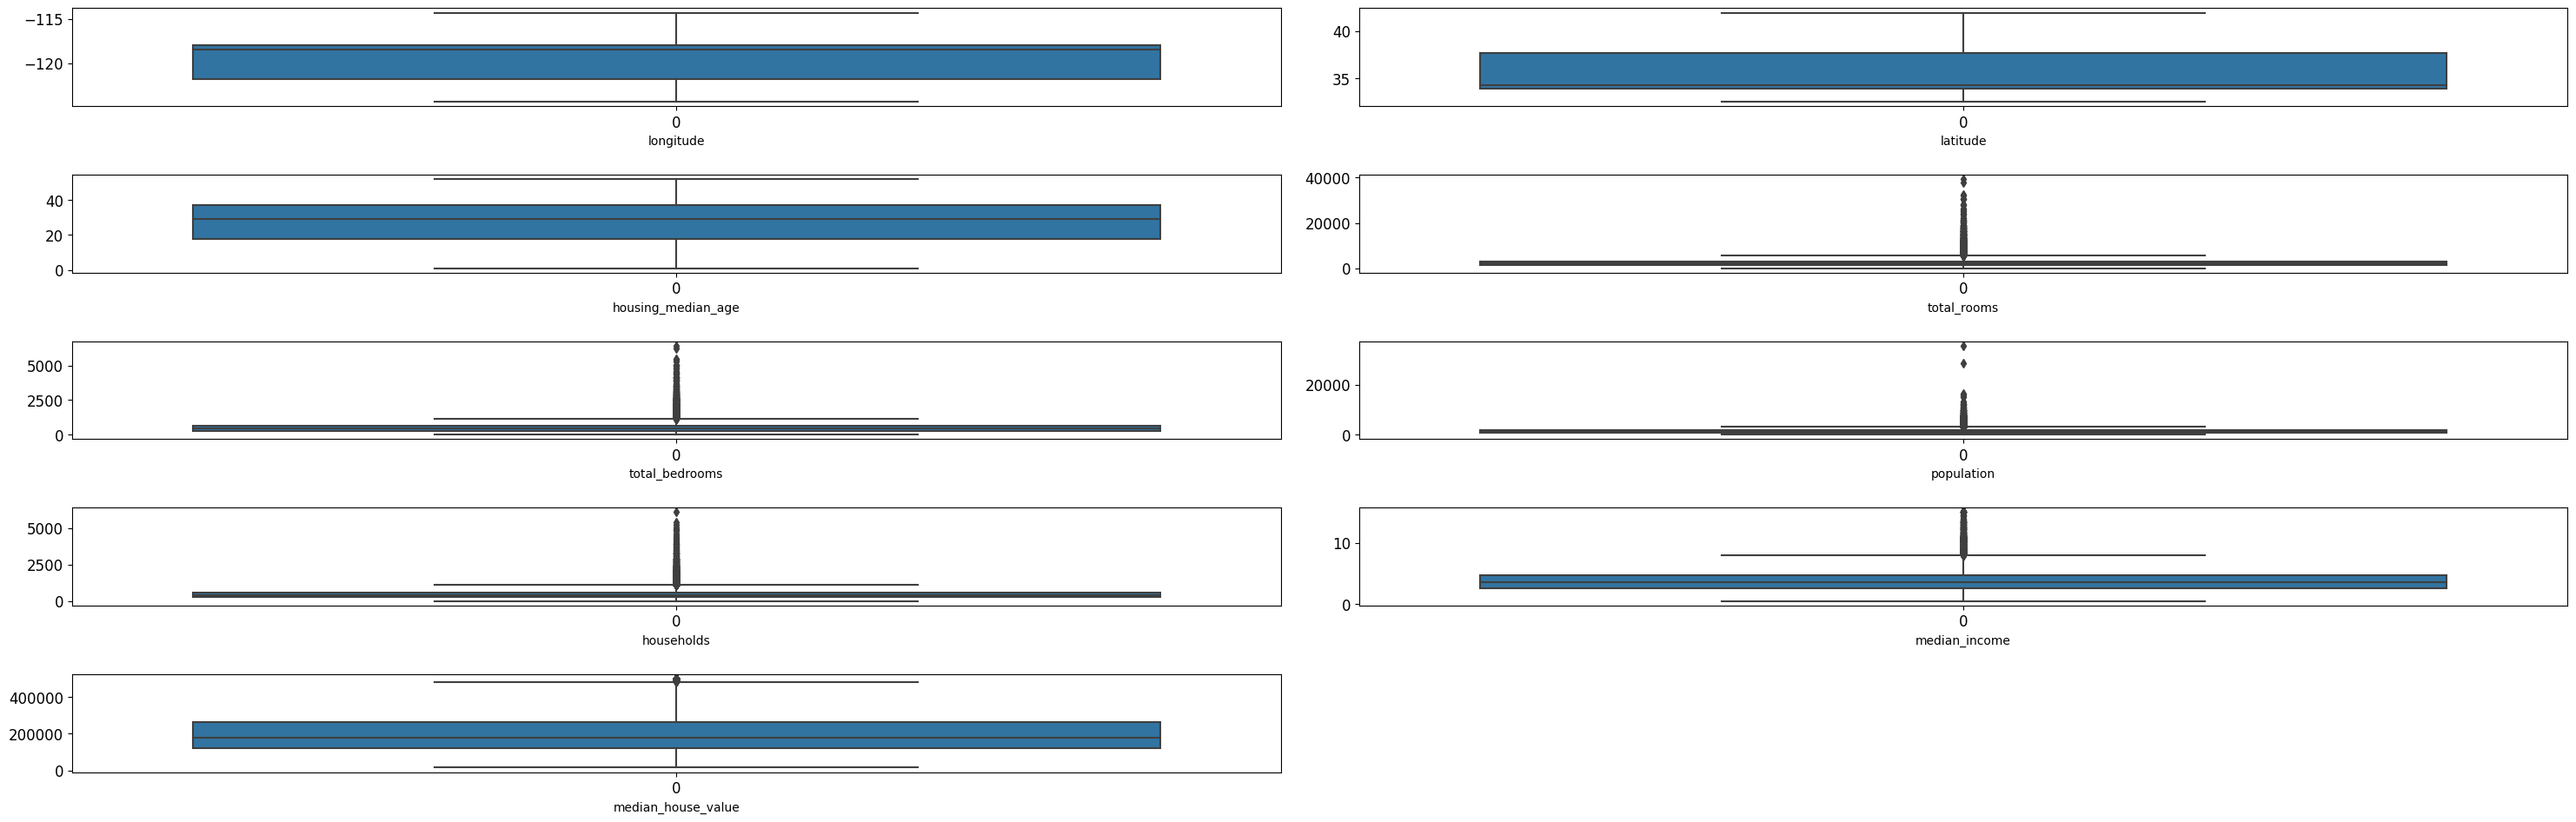

In [25]:
plt.figure(figsize=(30,40))
for i, col in enumerate(housing.columns):
    if housing[col].dtype != 'object':
        ax = plt.subplot(21, 2, i+1)
        sns.boxplot(housing[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)

plt.show()

In [26]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [27]:
import numpy as np

# For illustration only. Sklearn has train_test_split() [Implementation from scratch]
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [28]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [29]:
len(test_set)

4128

To ensure that the test set will remain consistent across multiple runs, even if the data is refreshed. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

In [30]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [31]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:

In [32]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [33]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

Since the housing dataset does not have an identifier column, the simplest solution is to use index as the ID.

If the row index is used as a unique identifier, it's neccesary to make sured that new data gets appended to the end of the dataset and that no row ever gets deleted.

If that's not possible, then it can be tried to buils a unique identifier. For example, a district's latitude and longitude are guareanteed to be stable for a few million years.

In [34]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']

In [35]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [36]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [37]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

**Notes:**

A purely random sampling method is generally fine if the dataset is large enough (specially relative to the number of attributes), but if it is not, there is a risk of introducing a significant sampling bias. To solver this, a technique called *stratified sampling*: the population is divided into homogeneus subgroups called *strata*, and right number of instances are sampled from each stratum to guarantee the that test set is representative of the overall population. Otherwise, the selection result would be significantly biased.

In [38]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


It is supposed that the experts in this housing sataset say that the median income is a very important attribute to predict the median housing prices. To ensure that the test set is representative of the various categories of incomes in the whole dataset, an income category attribute  has to be created.

It is important to have a sufficient number of instances in the dataset of each stratum, or else the estimate of a stratum's importance may be biased. This means that it should not have too many strata, and each stratum should be large enough.

<AxesSubplot:>

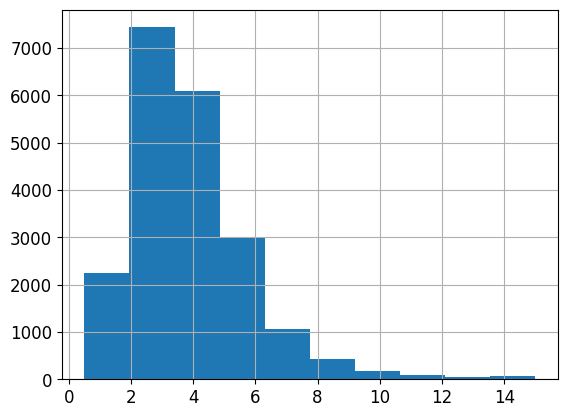

In [39]:
housing['median_income'].hist()

The following code uses the pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [40]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [41]:
housing['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

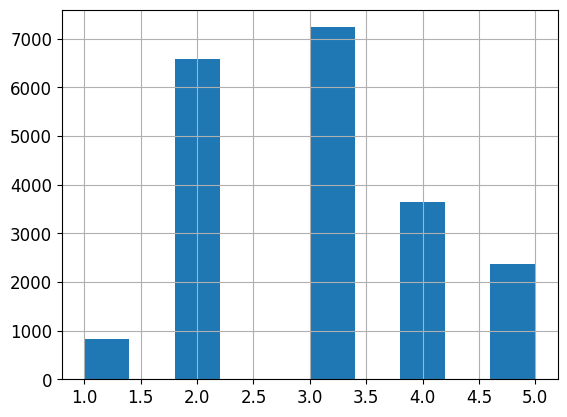

In [42]:
housing['income_cat'].hist()

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [44]:
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\model_selection\_split.py:1499: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\model_selection\_split.py:1499: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to speci

In [45]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [46]:
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

With similar code the income category proportions can be measured in the full dataset.

In [47]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    'Overall': income_cat_proportions(housing),
    'Stratified': income_cat_proportions(strat_test_set),
    'Random': income_cat_proportions(test_set),
}).sort_index()
compare_props['Rand. %error'] = 100 * compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Strat. %error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100

In [48]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


The test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed.

# Discover and Visualize the Data to Gain Insights
If the training set is very large, a sample exploration set may be used to explore the data. For this case, the set is quite small, so it can be directly used.

In [49]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

Saving figure bad_visualization_plot


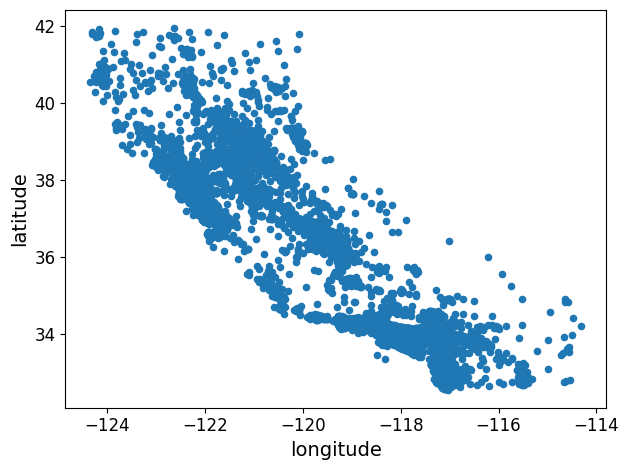

In [50]:
# Graphing the geographical information by latitude and longitude and using a scatterplot of all districts
housing.plot(kind='scatter', x='longitude', y='latitude')
save_fig('bad_visualization_plot')

Saving figure better_visualization_plot


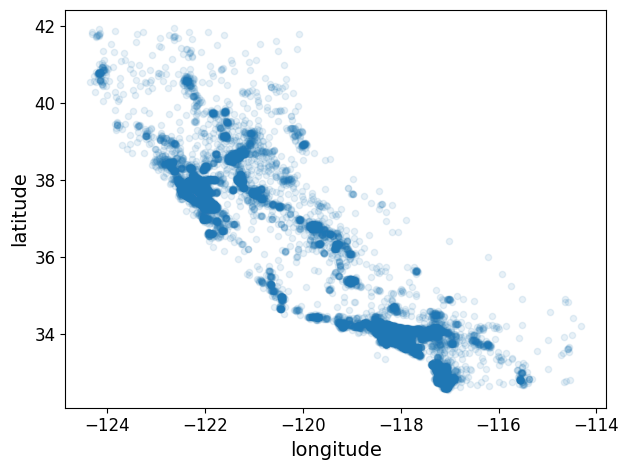

In [51]:
# To visualize some particular patterns, the alpha option has to be set to 0.1
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
save_fig('better_visualization_plot')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

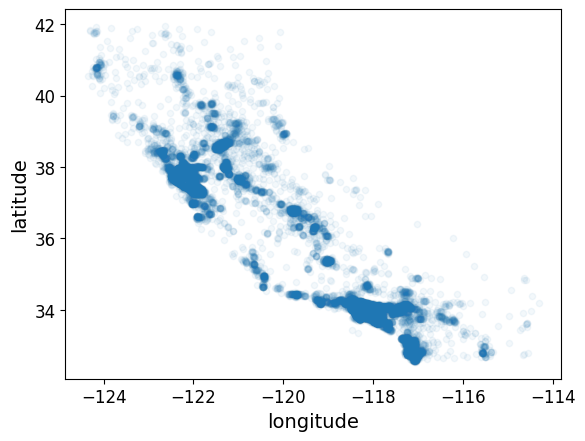

In [52]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.05)

# Looking for correlations
Since the dataser is not too large, the *Standard Correlation Coefficient* (also called Pearson's r) can be easily computed between every pair of attributes using the `corr()` method:

In [53]:
corr_matrix = housing.corr()

In [54]:
# Looking tha attribute correlation with 'median_house_value'
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Correlation coefficient ranges from -1 to 1 (weak to strong correlation). When the coefficient is close to –1, it means that there is a strong negative correlation; it can be seen a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north).

Coefficients close to 0 means that there is no linear correlation between horizontal and vertical axes.

**The correlation coefficient only measures linear correlations ('if x goes up, then y generally goes up/down').**


Another way to check for correlation between attributes is to use the pandas `scatter_matrix()` function, which plots every numerical attribute against every other numerical attribute.

In [55]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

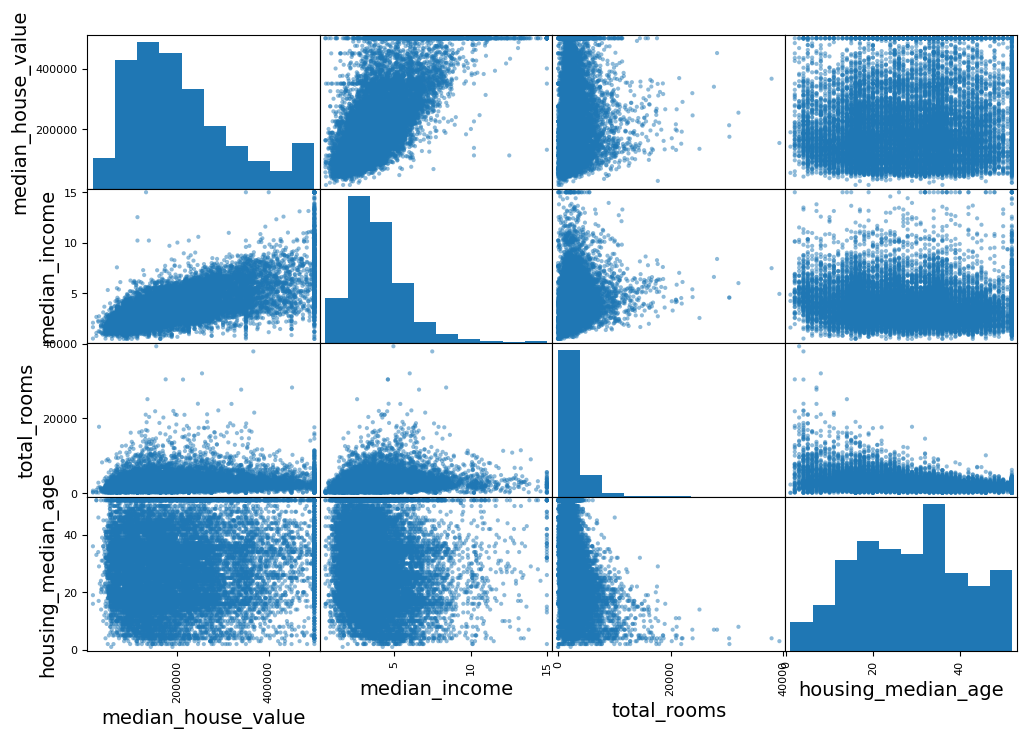

In [56]:
scatter_matrix(housing[attributes], figsize=(12,8))

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot.

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

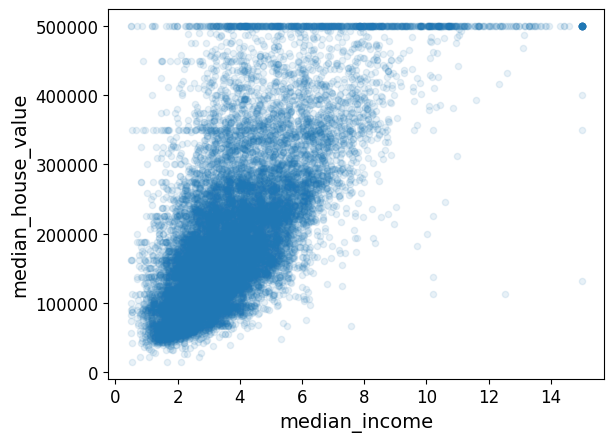

In [57]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; the upward trend can clearly be seen, and the points are not too dispersed. Second, the price cap noticed earlier is clearly visible as a horizontal line at \$500,000. But this plot reveals other less obvious straight lines: a horizontal line around \$450,000, another around \$350,000, perhaps one around \$280,000, and a few more below that.

To prevent the algorithms from learning to reproduce these data quirks, it may be neccesary to try removing the corresponding districts.

# Experimenting with Attribute Combinations
One last thing that may be wanted to be done before preparing the data for Machine Learninh algorithms is try out various attribute combinations. For example, the total numbers of rooms in a district is not very useful if the number of households is unknown. The number of rooms per household is the important data.

In [58]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']

In [59]:
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']

In [60]:
housing['population_per_household'] = housing['population']/housing['households']

In [61]:
# Look at the correlation matrix again:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new `bedrooms_per_room` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently, houses with a lower bedroom/ratio tend to be more expensive. The rooms_per_household is also more informative than the total_rooms attribute -the larger the houses, the more expensive they are-.

# Prepare the data for Machine Learning algorithm
Instead of doing this manually, functions should be written for this purpose, for several good reasons:
* This will allows to reproduce these transformations easily on any dataset (e.g., the next time a fresh dataset is getting).
* Gradually a library of transformation functions can be built that can be reused in future projects.
* These functions canb be used in the live system to transform the new data before feeding it to the algorithms.
* This will make it possible to easily try various transformations and see which combination of transformations works best.

But first, let's revert to a clean training set by copying `strat_train_set` once again. Also separate the predictors and the labels, since it doesn't  necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set).

In [62]:
housing = strat_train_set . drop ( 'median_house_value' , axis = 1 )
housing_labels = strat_train_set [ 'median_house_value' ] . copy ()

# Data Cleaning
Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them.

The `total_bedrooms` attribute has some missing values, the options are:
1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the values to some value (zero, the mean, the median, etc.).

These options can be easily accomplished by using the DataFrame's `dropna()`, `drop()`, and `fillna()` methods:


In [63]:
housing.dropna (subset=['total_bedrooms']) # option 1
housing.drop('total_bedrooms', axis=1) # option 2
median = housing ['total_bedrooms'].median() # option 3
housing['total_bedrooms'].fillna(median, inplace=True)

Scikit-Learn provides a handy class to take care of missing values: `SimpleImputer`

In [64]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [65]:
# Since the median can only be computed on numerical attributes, it's neccesary to create a copy of the data without the text attribute ocean_proximity
housing_num = housing.drop('ocean_proximity', axis=1)

In [66]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

The `imputer` has simply computed the median of each attribute and stored the result in its `statistics_` instance variable. Only the `total_bedrooms` attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the `imputer` to all the numerical attributes:

In [67]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [68]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now this “trained” imputer can be used to transform the training set by replacing missing values with the learned medians:

In [69]:
X = imputer.transform(housing_num)

In [70]:
# Put it back into a pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [71]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,3.0
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,4.0
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,2.0
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,3.0
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,3.0


# Handling text and categorical attributes
In this dataset, there is just one text attribute: the `ocean_proximity`.


In [72]:
housing_cat = housing[['ocean_proximity']]

In [73]:
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Each of values represents a category. This is called a categorical attribute. Most ML algorithms prefer to work with numbers, so it's a good idea to convert these categories from text to numbers by using the `OrdinalEncoder` class:

In [74]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [75]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros_like(X, dtype=np.int)
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
De

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [76]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is "<1H OCEAN" (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding , because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes. Scikit-Learn provides a OneHotEncoder class to convert categorical values into one-hot vectors:

In [77]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = check_array(X, dtype=np.int)
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The output is a SciPy sparse matrix, instead of a NumPy array. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements.

It can ben used mostly like a normal 2D array, but it can also be converted into a (dense) NumPy array:

In [78]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [79]:
cat_encoder . categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# Custom Transformers
Although Scikit-Learn provides many useful transformers, it will need to write its own for tasks such as custom cleanup operations or combining specific attributes. It will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods: fit() (returning self ), transform() , and fit_transform() . You can get the last one for free by simply adding TransformerMixin as a base class. If you add BaseEstimator as a base class (and avoid *args and **kargs in your constructor), you will also get two extra methods ( get_params() and set_params() ) that will be useful for automatic hyperparameter tuning.


Let's create a custom transformer to add extra attributes:

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

Note that I hard coded the indices (3, 4, 5, 6) for concision and clarity in the book, but it would be much cleaner to get them dynamically, like this:

In [81]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

Also, housing_extra_attribs is a NumPy array, we've lost the column names (unfortunately, that's a problem with Scikit-Learn). To recover a DataFrame, you could run this:

In [82]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,2,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,5,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,2,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,2,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,3,4.50581,3.047847


# Feature Scaling
With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales.

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

* Min-max scaling (many people call this ***normalization*** ) is the simplest: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if, for some reason, you don’t want 0–1.
* Standardization is different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, **standardization is much less affected by outliers.** Scikit-Learn provides a transformer called `StandardScaler` for standardization .

**WARNING!**
As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).

#Transformation Pipelines
As it's seen, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations.

In [83]:
# Small pipeline for the numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps. **All but the last estimator must be transformers** (i.e., they must have a `fit_transform()` method). The names can be anything you like (as long as they are unique and don’t contain double underscores, __ ); they will come in handy later for hyperparameter tuning.

When you call the pipeline’s `fit()` method, it calls fit_transform() `Inline code` sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it calls the `fit()` method.

The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a `StandardScaler` , which is a transformer, so the pipeline has a `transform()` method that applies all the transforms to the data in sequence (and of course also a `fit_transform()` method, which is the one we used).

In [84]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Having a single transformer able to handle all columns would be more convenient. Fortunately, Sickit-Learn introduced the `ColumnTransformer` for this purpose.

In [85]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num) # get the list of numerical column names
cat_attribs = ["ocean_proximity"] # list of categorical column names

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), # tuple: name, a transformer, and a list of names (or indices), returns a dense matrix
        ("cat", OneHotEncoder(), cat_attribs), # OneHotEncoder retunrs a sparse matrix
    ])

housing_prepared = full_pipeline.fit_transform(housing) # ColumnTransformer applies each transformer to the appropiate columns and concatenates the outputs along the second axis

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = check_array(X, dtype=np.int)
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

In [86]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [87]:
housing_prepared.shape

(16512, 17)

This is how we have a preprocessing pipeline that takes the full housing data and applies the appropriate transformations to each column.

**TIP**

Instead of using a transformer, you can specify the string "`drop`" if you want the columns to be dropped, or you can specify "`passthrough`" if you want the columns to be left untouched. By default, the remaining columns (i.e., the ones that were not listed) will be dropped, but you can set the remainder hyperparameter to any transformer (or to "`passthrough`") if you want these columns to be handled differently.

# Select and train a model


## Train a Linear Regression model:

In [88]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [89]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

In [90]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [91]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [203682.37379543 326371.39370781 204218.64588245  58685.4770482
 194213.06443039]


c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros_like(X, dtype=np.int)
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
De

Compare against the actual values:

In [92]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


The predictions are not exactly accurate (e.g., the first prediction is off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s `mean_squared_error()` function:

In [93]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.64295459937

Most districts’ **median_housing_values** range between \$120,000 and \$265,000, so a typical prediction error of \$68,628 is not very satisfying. **This is an example of a model underfitting the training data.**

When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

The main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, which rules out the last option. You could try to add more features (e.g., the log of the population), but first let’s try a more complex model to see how it does.


**Note**: since Scikit-Learn 0.22, you can get the RMSE directly by calling the mean_squared_error() function with squared=False

In [94]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49508.08205970911

## Train a DecisionTreeRegressor

In [95]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [96]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Having no error at this time, it is much more likely that **the model has badly overfit the data.**

# Better Evaluation Using Cross-Validation
The following code randomly splits the training set into 10 distinct subsets called folds , then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [97]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar 

**Warning**

Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes -scores before calculating the square root.

In [98]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70274.7991723  67258.3624668  71350.42593227 68882.91340979
 70987.99296566 74177.52037059 70788.57311306 70850.53018019
 76430.62239321 70212.6471067 ]
Mean: 71121.4387110585
Standard deviation: 2434.3080046605132


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately 71,407, generally ±2,439. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

In [99]:
# Computing the same scores for the Linear Regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66877.52325028 66608.120256   70575.91118868 74179.94799352
 67683.32205678 71103.16843468 64782.65896552 67711.29940352
 71080.40484136 67687.6384546 ]
Mean: 68828.99948449328
Standard deviation: 2662.7615706103397


c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar 

The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

## Train RandomForestRegressor
Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called **Ensemble Learning**, and it is often a great way to push ML algorithms even further.

In [100]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#de

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [101]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


18626.45217719628

In [102]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar 

Scores: [49633.454487   47565.18736589 50034.52343496 52444.25008076
 49463.18392461 53515.10766804 48577.59023701 47678.90315126
 53433.75372939 49947.64462367]
Mean: 50229.359870258486
Standard deviation: 2082.3174179664184


c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [103]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar 

count       10.000000
mean     68828.999484
std       2806.797143
min      64782.658966
25%      67078.972952
50%      67699.468929
75%      70954.281428
max      74179.947994
dtype: float64

Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

Before dive much deeper into Random Forest, you should try out many other models from various categories of ML algorithms. The goal is to shortlist a few (two to five) promising models.

## Saving the models
You should save every model you experiment with so that you can come back easily to any model you want. Is necessary to save:
* Both the hyperparameters and the trained parameters.
* The cross-validation scores.
* Perhaps actual predictions as well.

To save the models, the Python's `pickle` module or `joblib` library can be used, which is more efficient at serializing large NumPy arrays.

In [104]:
import joblib
joblib.dump(forest_reg, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")

In [105]:
print("Predictions:\t", my_model_loaded.predict(housing_prepared))

c:\Users\juan.chavezs\Desktop\repo\itesm-mlops\venv\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Predictions:	 [263527.   331884.02 221119.   ... 105722.   213199.   459125.66]
